In [1]:
#general libraries
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#preprocessing
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.model_selection import train_test_split
#machine learning algorithms
from sklearn.linear_model import Lasso
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor,AdaBoostRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
#metrics
from sklearn.metrics import mean_squared_error,mean_squared_log_error,explained_variance_score,r2_score

C:\Users\Carlos\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 300)


<h3><center>Project Summary</center></h3>    

In the last couple of years migrant and refugee numbers have been rising. Each year millions leave their countries in hope of a better future and hundreds of thousands cross the meditarenean to find a better life. Unfortunately the reality for most of them will not resemble their dreams. 

The migrant crisis of 2015 came as big surprise for european the the european population and policymakers. So the question is: "Is it possible to predict the number of migrants" based on socioeconomic features. Can a machine learning algorithm solve the question? 



<h3><center>Caveats</center></h3>

Lack of data:
There are a couple of problems that need to be mentioned. The biggest is to get the precise numbers of migrants that leave a given country for a given period. Most developing countries don't record data on a regular basis or for longer periods. There is also the problem that migration flows not only occur  between developing countries and developed countries but also between developing countries.

Migration versus refugee:
For this project I will only focus on migrants i.e. persons that are moving to another to improve their economic situation. In theory there is a clear distinction between between migrants and refugees i.e. persons that left their country to escape war, persecution, or natural disaster.

Hidden migration:
Due to the difficulty of getting a residence/work permit there is an unknown quantity of foreign nationals living in developing countries that is not counted in the statistics.


Note: The project is ongoing so there will be lots of changes in the future.

<center><h3>1. Loading and manipulating the data files</h3></center>

The datafiles come from three sources. 
<br>World Bank:<br>
https://data.worldbank.org/
<br>United Nations: <br>
http://hdr.undp.org/en/data
<br>OECD:<br>
http://www.oecd.org/migration/mig/oecdmigrationdatabases.htm

<h3>Datafiles from The World Bank</h3>

In [3]:
gdp =  pd.read_csv('data/datafiles/GDP.csv')
inflation = pd.read_csv('data/datafiles/inflation.csv')
population_growth = pd.read_csv('data/datafiles/population_growth.csv')
unemployment = pd.read_csv('data/datafiles/unemployment.csv')
rural_population = pd.read_csv('data/datafiles/rural_population.csv')

<h5>Countries of origin</h5>

In [4]:
countries = ('Angola','Algeria', 'Burundi', 'Benin', 'Burkina Faso', 'Botswana',
       'Central African Republic', 'Cote d Ivoire',
       'Democratic Republic of the Congo', 'Djibouti', 'Egypt', 'Eritrea',
       'Ethiopia', 'Gabon', 'Ghana', 'Guinea', 'Gambia', 'Guinea-Bissau',
       'Equatorial Guinea', 'Kenya', 'Liberia', 'Libya', 'Lesotho',
       'Morocco', 'Madagascar', 'Mali', 'Mozambique', 'Mauritania',
       'Mauritius', 'Malawi', 'Namibia', 'Niger', 'Nigeria', 'Rwanda',
       'Sierra Leone', 'Swaziland', 'Togo', 'Tunisia', 'Tanzania',
       'Uganda', 'South Africa', 'Zambia', 'Zimbabwe')

In [5]:
dflist = (gdp,inflation,population_growth,unemployment, rural_population)

In [6]:
for df in dflist:
    print(df.shape)


(264, 64)
(264, 64)
(264, 64)
(264, 64)
(264, 64)


In [7]:
for df in dflist:
    df.drop(list(df)[3:44], axis=1,inplace=True)

In [8]:
for df in dflist:
    df.drop(list(df)[20:23], axis=1,inplace=True)

In [9]:
#period of interest for unpivot
period = ['2000','2001','2002','2003','2004','2005','2006','2007','2008','2009','2010','2011','2012','2013','2014','2015','2016',]

In [10]:
#Columns  to use as identifier variables
columns = ['Country Name','Country Code']

In [11]:
def pivot_frame(df):
    df = df.melt(id_vars=columns, value_vars=period)
    return df
    

<h4>Gdp</h4>

In [12]:
gdp = pivot_frame(gdp)

In [13]:
gdp.head(2)
    

,Country Name,Country Code,variable,value
0,Aruba,ABW,2000,20620.700626
1,Afghanistan,AFG,2000,NaN


In [14]:
gdp.rename({'variable': 'Year','value':'Gdp_capita'},axis=1,inplace=True)

<h4>Inflation</h4>

In [15]:
inflation = pivot_frame(inflation)

In [16]:
inflation.rename({'variable': 'Year','value':'Inflation'},axis=1,inplace=True)

In [17]:
inflation.head(2)

,Country Name,Country Code,Year,Inflation
0,Aruba,ABW,2000,1.04827
1,Afghanistan,AFG,2000,NaN


<h3>Population Growth</h3>

In [18]:
population_growth = pivot_frame(population_growth)

In [19]:
population_growth.rename({'variable': 'Year','value':'Population_growth'},axis=1,inplace=True)

In [20]:
population_growth.head(2)

,Country Name,Country Code,Year,Population_growth
0,Aruba,ABW,2000,2.055027
1,Afghanistan,AFG,2000,2.975053


<h3>Unemployment</h3>

In [21]:
unemployment = pivot_frame(unemployment)

In [22]:
unemployment.rename({'variable': 'Year','value':'Unemployment'},axis=1,inplace=True)

In [23]:
unemployment.head(2)

,Country Name,Country Code,Year,Unemployment
0,Aruba,ABW,2000,NaN
1,Afghanistan,AFG,2000,3.517


<h3>Rural Population</h3>

In [24]:
rural_population = pivot_frame(rural_population)

In [25]:
rural_population.rename({'variable': 'Year','value':'Rural_population'},axis=1,inplace=True)

In [26]:
rural_population.head(2)

,Country Name,Country Code,Year,Rural_population
0,Aruba,ABW,2000,53.283
1,Afghanistan,AFG,2000,77.922


<h3>Merge all 5 datafiles into one</h3>

In [27]:
all_data = gdp.merge(inflation,on=['Country Name','Year','Country Code']).merge(rural_population,on=['Country Name','Year','Country Code'],how='left').merge(unemployment,on=['Country Name','Year','Country Code'],how='left').merge(population_growth,on=['Country Name','Year','Country Code'],how='left')


In [28]:
all_data.head(2)

,Country Name,Country Code,Year,Gdp_capita,Inflation,Rural_population,Unemployment,Population_growth
0,Aruba,ABW,2000,20620.700626,1.04827,53.283,NaN,2.055027
1,Afghanistan,AFG,2000,NaN,NaN,77.922,3.517,2.975053


In [29]:
all_data = all_data[all_data['Country Name'].isin(countries)]

In [30]:
all_data = all_data.sort_values(by=['Country Name', 'Country Code','Year']).reset_index(drop=True)

In [31]:
all_data.head(5)

,Country Name,Country Code,Year,Gdp_capita,Inflation,Rural_population,Unemployment,Population_growth
0,Algeria,DZA,2000,1765.022577,22.654767,40.081,29.770000,1.358408
1,Algeria,DZA,2001,1740.606649,-0.481508,39.288,27.299999,1.309843
2,Algeria,DZA,2002,1781.826864,1.311488,38.499,25.900000,1.275066
3,Algeria,DZA,2003,2103.381467,8.328836,37.716,23.719999,1.275915
4,Algeria,DZA,2004,2609.952692,12.245876,36.939,17.650000,1.317846


<h3>Nans from the first five  datafiles</h3>

In [32]:
all_data.isna().sum()

Country Name          0
Country Code          0
Year                  0
Gdp_capita            5
Inflation            20
Rural_population      5
Unemployment          0
Population_growth     5
dtype: int64

<h3>Dealing with Nans</h3>

<h4>Population_growth:</h4>

In [33]:
all_data[all_data.Population_growth.isna()]

,Country Name,Country Code,Year,Gdp_capita,Inflation,Rural_population,Unemployment,Population_growth
216,Eritrea,ERI,2012,NaN,NaN,NaN,6.926,NaN
217,Eritrea,ERI,2013,NaN,NaN,NaN,6.955,NaN
218,Eritrea,ERI,2014,NaN,NaN,NaN,6.867,NaN
219,Eritrea,ERI,2015,NaN,NaN,NaN,6.807,NaN
220,Eritrea,ERI,2016,NaN,NaN,NaN,6.684,NaN


In [34]:
all_data[all_data['Country Name']=='Eritrea']

,Country Name,Country Code,Year,Gdp_capita,Inflation,Rural_population,Unemployment,Population_growth
204,Eritrea,ERI,2000,308.133784,24.977595,73.413,6.861,2.428957
205,Eritrea,ERI,2001,316.823820,15.077270,72.545,6.446,3.527409
206,Eritrea,ERI,2002,293.955791,16.148667,71.659,6.864,4.380470
207,Eritrea,ERI,2003,334.585443,21.872842,70.756,6.817,4.720052
208,Eritrea,ERI,2004,407.769977,24.799286,69.836,6.857,4.467385
209,Eritrea,ERI,2005,388.595123,7.623689,68.901,6.716,3.853600
210,Eritrea,ERI,2006,415.036599,11.394004,67.949,6.629,3.187325
211,Eritrea,ERI,2007,439.832690,7.288208,66.983,6.360,2.648825
212,Eritrea,ERI,2008,450.632840,16.076220,66.000,6.107,2.186572
213,Eritrea,ERI,2009,595.109987,29.504507,65.415,6.832,1.848469


In [35]:
all_data['Population_growth'].fillna(1.363875,inplace=True)

In [36]:
all_data['Rural_population'].fillna(64.229,inplace=True)

In [37]:
all_data['Gdp_capita'].fillna(811.376029,inplace=True)

<h4>Inflation:</h4> 

Eritrea: Add manually the missing data from: <br>
Cia Worldfactbook 2016 --> 9% <br>
Trading Economics (2015 --> 12.5, 2014 --> 11.4, 2013 --> 12.27, 2012 --> 12.25

In [38]:
all_data.loc[(all_data['Country Name']=='Eritrea')
         &(all_data['Year']=='2016'), 'Inflation']= 9.00
all_data.loc[(all_data['Country Name']=='Eritrea')
         &(all_data['Year']=='2015'), 'Inflation']= 12.50
all_data.loc[(all_data['Country Name']=='Eritrea')
         &(all_data['Year']=='2014'), 'Inflation']= 11.40
all_data.loc[(all_data['Country Name']=='Eritrea')
         &(all_data['Year']=='2013'), 'Inflation']= 12.27
all_data.loc[(all_data['Country Name']=='Eritrea')
         &(all_data['Year']=='2012'), 'Inflation']= 12.25

In [39]:
all_data[all_data['Inflation'].isna()]

,Country Name,Country Code,Year,Gdp_capita,Inflation,Rural_population,Unemployment,Population_growth
153,Djibouti,DJI,2000,768.176077,NaN,23.468,13.636,2.484539
154,Djibouti,DJI,2001,780.908223,NaN,23.422,13.613,2.127615
155,Djibouti,DJI,2002,791.389478,NaN,23.376,13.608,1.882137
156,Djibouti,DJI,2003,818.866630,NaN,23.330,13.294,1.685842
157,Djibouti,DJI,2004,863.231612,NaN,23.284,13.002,1.562422
158,Djibouti,DJI,2005,904.729749,NaN,23.239,12.697,1.498687
159,Djibouti,DJI,2006,967.668623,NaN,23.193,11.784,1.433524
160,Djibouti,DJI,2007,1052.725652,NaN,23.147,11.029,1.361009
161,Djibouti,DJI,2008,1223.856861,NaN,23.101,10.779,1.345062
162,Djibouti,DJI,2009,1267.312801,NaN,23.056,11.717,1.394638


In [40]:
all_data.loc[(all_data['Country Name']=='Liberia')
         &(all_data['Year']=='2000'), 'Inflation']= 5.00

The inflation data that the Worldbank datafiles use is the GDP Price Deflator. Unfortunately Djibouti has no data for most years. As aproximation I will use the Consumer Price Index (CPI). <br>

The GDP Deflator measures the change in prices of all goods and services while the CPI is a only looks at goods bought by consumers. 


In [41]:
Djibouti_Cpi = pd.read_csv('data/datafiles/djibouti_cpi.csv')

In [42]:
Djibouti_Cpi.drop(list(Djibouti_Cpi)[2:44], axis=1,inplace=True)

In [43]:
Djibouti_Cpi.drop(list(Djibouti_Cpi)[19:23], axis=1,inplace=True)

In [44]:
Djibouti_Cpi = pivot_frame(Djibouti_Cpi)

In [45]:
Djibouti_Cpi.rename({'value':'cpi'},axis=1 ,inplace=True)

In [46]:
Djibouti_Cpi.head(2)

,Country Name,Country Code,variable,cpi
0,Djibouti,DJI,2000,1.746652
1,Djibouti,DJI,2001,1.746652


In [47]:
Djibouti_Cpi['cpi'].values

array([ 1.74665225,  1.74665225,  0.63761955,  1.98196735,  3.12226205,
        3.1049664 ,  3.483407  ,  4.96597655, 11.95862069,  1.67549587,
        3.95007876,  5.06871395,  3.73120951,  2.70603243,  1.34186494,
       -0.84738973,  2.73841209])

In [48]:
all_data['Inflation'].fillna(Djibouti_Cpi['cpi'].values[0],inplace=True)


In [49]:
all_data.isna().sum()

Country Name         0
Country Code         0
Year                 0
Gdp_capita           0
Inflation            0
Rural_population     0
Unemployment         0
Population_growth    0
dtype: int64

In [50]:
all_data[all_data.Population_growth.isna()]

,Country Name,Country Code,Year,Gdp_capita,Inflation,Rural_population,Unemployment,Population_growth


In [51]:
all_data[all_data['Country Name']=='Eritrea']

,Country Name,Country Code,Year,Gdp_capita,Inflation,Rural_population,Unemployment,Population_growth
204,Eritrea,ERI,2000,308.133784,24.977595,73.413,6.861,2.428957
205,Eritrea,ERI,2001,316.823820,15.077270,72.545,6.446,3.527409
206,Eritrea,ERI,2002,293.955791,16.148667,71.659,6.864,4.380470
207,Eritrea,ERI,2003,334.585443,21.872842,70.756,6.817,4.720052
208,Eritrea,ERI,2004,407.769977,24.799286,69.836,6.857,4.467385
209,Eritrea,ERI,2005,388.595123,7.623689,68.901,6.716,3.853600
210,Eritrea,ERI,2006,415.036599,11.394004,67.949,6.629,3.187325
211,Eritrea,ERI,2007,439.832690,7.288208,66.983,6.360,2.648825
212,Eritrea,ERI,2008,450.632840,16.076220,66.000,6.107,2.186572
213,Eritrea,ERI,2009,595.109987,29.504507,65.415,6.832,1.848469


In [52]:
all_data.isna().sum()

Country Name         0
Country Code         0
Year                 0
Gdp_capita           0
Inflation            0
Rural_population     0
Unemployment         0
Population_growth    0
dtype: int64

<h2><center>Data from UN / Human Development Data</center></h2>

<h3>Human Development Index / HDI</h3>

In [53]:
hdi = pd.read_csv('data/datafiles/HDI.csv')
education = pd.read_csv('data/datafiles/Education_Index.csv',sep=';')
Foreign_investment = pd.read_csv('data/datafiles/Foreign_investment.csv',delimiter=';')
Unemployment_youth = pd.read_csv('data/datafiles/Unemployment_Youth.csv',delimiter=';')
Mean_years_school = pd.read_csv('data/datafiles/Mean years of schooling.csv',delimiter=';')


<h3>Youth Unemployment</h3>

In [54]:
Unemployment_youth.drop(['HDI Rank (2017)','1991','1995'],axis=1,inplace=True)

In [55]:
Unemployment_youth.head(2)

,Country,2000,2005,2010,2011,2012,2013,2014,2015,2016,2017
0,Afghanistan,23.6,17.3,16.5,17.3,16.6,17.5,17.9,18.1,17.9,17.7
1,Albania,35.6,31.1,29.2,28.8,27.7,30.5,39.4,40.1,32.7,30.0


Fill the values and the missing Years between 2000 and 2010

In [56]:
Unemployment_youth['2001']= Unemployment_youth['2000']+ ((Unemployment_youth['2005']-Unemployment_youth['2000'])*0.20)
Unemployment_youth['2002']= Unemployment_youth['2000']+ ((Unemployment_youth['2005']-Unemployment_youth['2000'])*0.40)
Unemployment_youth['2003']= Unemployment_youth['2000']+ ((Unemployment_youth['2005']-Unemployment_youth['2000'])*0.60)
Unemployment_youth['2004']= Unemployment_youth['2000']+ ((Unemployment_youth['2005']-Unemployment_youth['2000'])*0.80)
Unemployment_youth['2006']= Unemployment_youth['2005']+ ((Unemployment_youth['2010']-Unemployment_youth['2005'])*0.20)
Unemployment_youth['2007']= Unemployment_youth['2005']+ ((Unemployment_youth['2010']-Unemployment_youth['2005'])*0.40)
Unemployment_youth['2008']= Unemployment_youth['2005']+ ((Unemployment_youth['2010']-Unemployment_youth['2005'])*0.60)
Unemployment_youth['2009']= Unemployment_youth['2005']+ ((Unemployment_youth['2010']-Unemployment_youth['2005'])*0.80)


Reorder the columns 

In [57]:
Unemployment_youth = Unemployment_youth[['Country', '2000', '2001', '2002', '2003','2004','2005','2006',
                            
                            '2007','2008','2009','2010','2011','2012','2013','2014','2015','2016']]

In [58]:
columns = ['Country']

In [59]:
Unemployment_youth = pivot_frame(Unemployment_youth)

In [60]:
Unemployment_youth.head(2)

,Country,variable,value
0,Afghanistan,2000,23.6
1,Albania,2000,35.6


In [61]:
Unemployment_youth = Unemployment_youth[Unemployment_youth['Country'].isin(countries)]

In [62]:
Unemployment_youth.rename({'variable':'Year','value':'Unemployment_youth','Country':'Country Name'},axis = 1,inplace=True)


In [63]:
Unemployment_youth=Unemployment_youth.sort_values(by=['Country Name','Year'])

In [64]:
all_data = all_data.merge(Unemployment_youth,on=['Country Name','Year'],how='left')

In [65]:
all_data.head()

,Country Name,Country Code,Year,Gdp_capita,Inflation,Rural_population,Unemployment,Population_growth,Unemployment_youth
0,Algeria,DZA,2000,1765.022577,22.654767,40.081,29.770000,1.358408,52.00
1,Algeria,DZA,2001,1740.606649,-0.481508,39.288,27.299999,1.309843,47.74
2,Algeria,DZA,2002,1781.826864,1.311488,38.499,25.900000,1.275066,43.48
3,Algeria,DZA,2003,2103.381467,8.328836,37.716,23.719999,1.275915,39.22
4,Algeria,DZA,2004,2609.952692,12.245876,36.939,17.650000,1.317846,34.96


<h3>Education Index</h3>

In [66]:
education.head(2)

,HDI Rank (2017),Country,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
0,168,Afghanistan,235.0,247.0,259.0,271.0,302.0,312.0,324.0,336.0,347.0,359.0,371.0,382.0,390.0,398.0,406.0,410.0,410.0,415
1,68,Albania,588.0,589.0,598.0,605.0,606.0,623.0,629.0,642.0,646.0,652.0,673.0,693.0,730.0,732.0,733.0,733.0,742.0,745


In [67]:
education = pivot_frame(education)

In [68]:
education = education[education.Country.isin(countries)]

In [69]:
education.rename({'variable':'Year','value':'Education','Country':'Country Name'},axis = 1,inplace=True)

In [70]:
education.sort_values(by=['Country Name','Year'])
education['Year']=education['Year'].astype(str)

In [71]:
#africa_data = pd.merge(education_melted, africa_data, on=['Country Name','Year'])
all_data = all_data.merge(education,on=['Country Name','Year'],how='left')

In [72]:
all_data.head(2)

,Country Name,Country Code,Year,Gdp_capita,Inflation,Rural_population,Unemployment,Population_growth,Unemployment_youth,Education
0,Algeria,DZA,2000,1765.022577,22.654767,40.081,29.770000,1.358408,52.00,500.0
1,Algeria,DZA,2001,1740.606649,-0.481508,39.288,27.299999,1.309843,47.74,513.0


<h3>Foreign Investment</h3>

In [73]:
Foreign_investment.head(2)

,HDI Rank (2017),Country,1990,1995,2000,2005,2010,2011,2012,2013,2014,2015,2016,2017
0,168,Afghanistan,NaN,NaN,NaN,4.3,1.2,0.3,0.3,0.2,0.2,0.9,0.5,0.3
1,68,Albania,NaN,2.9,3.9,3.2,9.1,8.1,7.5,9.8,8.7,8.7,8.8,7.9


In [74]:
Foreign_investment.drop(['HDI Rank (2017)','1990','1995'],axis=1,inplace=True)

Fill the values and the missing Years between 2000 and 2010

In [75]:
Foreign_investment['2001']= Foreign_investment['2000']+ ((Foreign_investment['2005']-Foreign_investment['2000'])*0.20)
Foreign_investment['2002']= Foreign_investment['2000']+ ((Foreign_investment['2005']-Foreign_investment['2000'])*0.40)
Foreign_investment['2003']= Foreign_investment['2000']+ ((Foreign_investment['2005']-Foreign_investment['2000'])*0.60)
Foreign_investment['2004']= Foreign_investment['2000']+ ((Foreign_investment['2005']-Foreign_investment['2000'])*0.80)
Foreign_investment['2006']= Foreign_investment['2005']+ ((Foreign_investment['2010']-Foreign_investment['2005'])*0.20)
Foreign_investment['2007']= Foreign_investment['2005']+ ((Foreign_investment['2010']-Foreign_investment['2005'])*0.40)
Foreign_investment['2008']= Foreign_investment['2005']+ ((Foreign_investment['2010']-Foreign_investment['2005'])*0.60)
Foreign_investment['2009']= Foreign_investment['2005']+ ((Foreign_investment['2010']-Foreign_investment['2005'])*0.80)


Reorder the columns

In [76]:
Foreign_investment = Foreign_investment[['Country', '2000', '2001', '2002', '2003','2004','2005','2006',
                            
                            '2007','2008','2009','2010','2011','2012','2013','2014','2015','2016']]

In [77]:
Foreign_investment = pivot_frame(Foreign_investment)


In [78]:
Foreign_investment.rename({'variable':'Year','value':'Foreign_investment','Country':'Country Name'},axis = 1,inplace=True)

In [79]:
Foreign_investment = Foreign_investment[Foreign_investment['Country Name'].isin(countries)]

In [80]:
Foreign_investment=Foreign_investment.sort_values(by=['Country Name','Year'])

In [81]:
all_data = all_data.merge(Foreign_investment,on=['Country Name','Year'],how='left')

In [82]:
all_data.head(2)

,Country Name,Country Code,Year,Gdp_capita,Inflation,Rural_population,Unemployment,Population_growth,Unemployment_youth,Education,Foreign_investment
0,Algeria,DZA,2000,1765.022577,22.654767,40.081,29.770000,1.358408,52.00,500.0,0.50
1,Algeria,DZA,2001,1740.606649,-0.481508,39.288,27.299999,1.309843,47.74,513.0,0.62


<h3>HDI</h3>

In [83]:
hdi.drop(list(hdi)[2:12], axis=1,inplace=True)

In [84]:
hdi = pivot_frame(hdi)

In [85]:
hdi.rename({'variable':'Year','value':'Hdi','Country':'Country Name'},axis = 1,inplace=True)

In [86]:
hdi = hdi[hdi['Country Name'].isin(countries)]

In [87]:
hdi=hdi.sort_values(by=['Country Name','Year'])

In [88]:
all_data = all_data.merge(hdi,on=['Country Name','Year'],how='left')

In [89]:
all_data.head()

,Country Name,Country Code,Year,Gdp_capita,Inflation,Rural_population,Unemployment,Population_growth,Unemployment_youth,Education,Foreign_investment,Hdi
0,Algeria,DZA,2000,1765.022577,22.654767,40.081,29.770000,1.358408,52.00,500.0,0.50,0.644
1,Algeria,DZA,2001,1740.606649,-0.481508,39.288,27.299999,1.309843,47.74,513.0,0.62,0.653
2,Algeria,DZA,2002,1781.826864,1.311488,38.499,25.900000,1.275066,43.48,529.0,0.74,0.664
3,Algeria,DZA,2003,2103.381467,8.328836,37.716,23.719999,1.275915,39.22,542.0,0.86,0.674
4,Algeria,DZA,2004,2609.952692,12.245876,36.939,17.650000,1.317846,34.96,557.0,0.98,0.684


Save the cleaned data as datafile for future use

In [90]:
all_data.to_csv('data/outputfiles/cleaned_data_worldbank.csv')

<h3>The target variable Migration</h3>

Most Countries from where the migrants come from do not keep track of migration numbers. So in order to find out how many migrants come from a specific country I use data from the OECD that show the number of migrants that arrived from a given developing country and take the sum acrros all the developed (OECD) countries. 

In [91]:
raw_migration_data = pd.read_csv('data/datafiles/migration_oecd.csv',low_memory=False)

In [92]:
raw_migration_data.shape

(421899, 13)

In [93]:
raw_migration_data.head(2)

,CO2,Country of birth/nationality,VAR,Variable,GEN,Gender,COU,Country,YEA,Year,Value,Flag Codes,Flags
0,AFG,Afghanistan,B11,Inflows of foreign population by nationality,TOT,Total,AUS,Australia,2000,2000,887.0,NaN,NaN
1,AFG,Afghanistan,B11,Inflows of foreign population by nationality,TOT,Total,AUS,Australia,2001,2001,456.0,NaN,NaN


In [94]:
raw_migration_data.Variable.unique()

array(['Inflows of foreign population by nationality',
       'Outflows of foreign population by nationality',
       'Stock of foreign-born population by country of birth',
       'Inflows of asylum seekers by nationality',
       'Stock of foreign population by nationality',
       'Acquisition of nationality by country of former nationality',
       'Stock of foreign-born labour by country of birth',
       'Stock of foreign labour by nationality'], dtype=object)

The attribute variable groups the foreign population by several categories.

Aproach 1) Use the variable "Inflows of foreign population by nationality". Take the sum from all countries that received inflows from a given country. The sum should give an aproximadion of migrants for a specific origin country for a given year.

Example: Take all inflows of migrants in France that came from Algeria plus all the inflows of migrants in Germany that came from Algeria and continue through the rest of the receiving countries.

Drawback: If an Algerian citicen that allready lives in France would move to Germany, he/she would count as a new imigrant. The other problem is that imigrants that return to their home country are not included the Categories.

In [95]:
#drop features that hold double information or no migration relevant information
raw_migration_data.drop(columns=['Variable','GEN','YEA','Gender','Flag Codes','Flags'], axis=1, inplace = True)

In [96]:
#change variable label and Value for readabilty purpose
raw_migration_data.rename({'CO2': 'Country Code'},axis=1,inplace=True)
#raw_migration_data.rename({'Value': 'Migration'},axis=1,inplace=True)

In [97]:
raw_migration_data = raw_migration_data[raw_migration_data['Country of birth/nationality'].isin(countries)]

In [98]:
raw_migration_data.head(2)

,Country Code,Country of birth/nationality,VAR,COU,Country,Year,Value
1734,DZA,Algeria,B11,AUS,Australia,2000,56.0
1735,DZA,Algeria,B11,AUS,Australia,2001,60.0


In [99]:
raw_migration_data.drop(['Country Code','COU'],axis=1, inplace = True)

In [100]:
migration =raw_migration_data[raw_migration_data.VAR== 'B11'].copy()

In [101]:
migration.Country.unique().shape

(34,)

In [102]:
#Rename the column Value to Migration 
migration.rename({'Value':'Migration','Country of birth/nationality':'Country Name'},axis=1,inplace=True)


In [103]:
migration = migration.groupby(by=['Country Name','Year'])['Migration'].sum().reset_index() 

In [104]:
migration = migration[migration['Country Name'].isin(countries)]

In [105]:
migration.shape

(731, 3)

In [106]:
migration.head(2)

,Country Name,Year,Migration
0,Algeria,2000,24918.0
1,Algeria,2001,28388.0


In [107]:
migration['Year']=migration['Year'].astype(str)

In [108]:
migration.to_csv('data/outputfiles/migration.csv')

<h3>Merging the target variable and the predictors</h3>

In [109]:
africa = pd.merge(all_data, migration, on=['Country Name', 'Year'],how='left')


In [110]:
africa.head()

,Country Name,Country Code,Year,Gdp_capita,Inflation,Rural_population,Unemployment,Population_growth,Unemployment_youth,Education,Foreign_investment,Hdi,Migration
0,Algeria,DZA,2000,1765.022577,22.654767,40.081,29.770000,1.358408,52.00,500.0,0.50,0.644,24918.0
1,Algeria,DZA,2001,1740.606649,-0.481508,39.288,27.299999,1.309843,47.74,513.0,0.62,0.653,28388.0
2,Algeria,DZA,2002,1781.826864,1.311488,38.499,25.900000,1.275066,43.48,529.0,0.74,0.664,36637.0
3,Algeria,DZA,2003,2103.381467,8.328836,37.716,23.719999,1.275915,39.22,542.0,0.86,0.674,42361.0
4,Algeria,DZA,2004,2609.952692,12.245876,36.939,17.650000,1.317846,34.96,557.0,0.98,0.684,44840.0


In [111]:
#africa.isna().sum()
africa.fillna(0.00,inplace=True)

In [112]:
num_cols=list(africa.select_dtypes(exclude='object'))

In [113]:
for col in num_cols:
    print(africa[col].corr(africa.Migration),'  :' ,col)

0.045719609853089975   : Gdp_capita
-0.018981790788984647   : Inflation
-0.2282201994774082   : Rural_population
0.0691350445869624   : Unemployment
-0.22124117733892687   : Population_growth
0.07944279927300549   : Unemployment_youth
0.15880812062310995   : Education
-0.11320760876287932   : Foreign_investment
0.2650424295043424   : Hdi
0.9999999999999998   : Migration


<h3>Exploratory Data Analysis</h3>

The trap of thinking that poverty is an absolut, unfailable predictor<br>
When we look at the top ten countries in absolute numbers, there is one country that clearly stands out. 

In [114]:
countries_migration = africa.groupby(by=['Country Name'])['Migration'].sum()

In [115]:
top10= countries_migration.sort_values(ascending=False)[0:10]
countries=top10.index
values=top10.values

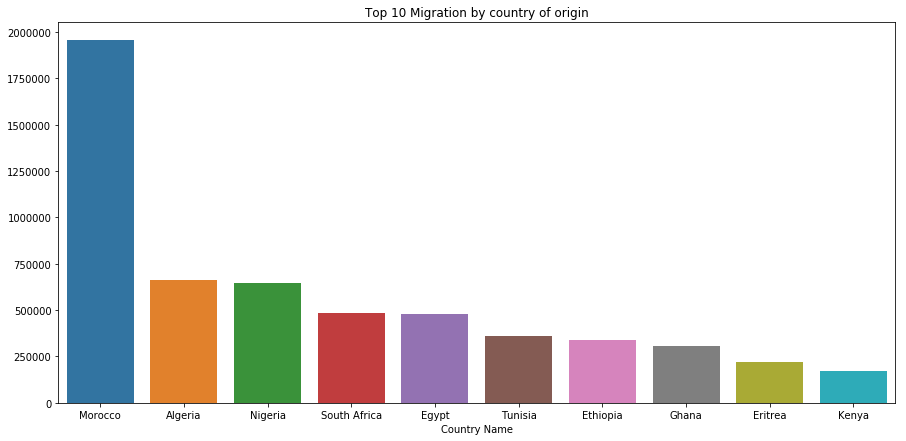

In [116]:
plt.figure(figsize=(15,7))
plt.title('Top 10 Migration by country of origin')
sns.barplot(countries,values)
plt.show()

In [117]:
africa_without_morocco= africa[(africa['Country Name']!='Morocco')]

In [118]:
for col in num_cols:
    print(africa_without_morocco[col].corr(africa_without_morocco.Migration),'  :' ,col)

0.06105519487510262   : Gdp_capita
-0.007578923232447435   : Inflation
-0.22358053271254305   : Rural_population
0.0908367945350324   : Unemployment
-0.1419563612638445   : Population_growth
0.14379628305791003   : Unemployment_youth
0.2865972148865496   : Education
-0.1312461871615101   : Foreign_investment
0.30134365631167176   : Hdi
1.0   : Migration


In [119]:
anual_migration = africa.groupby(by='Year')['Migration'].sum()

In [120]:
anual_migration_without_morocco = africa_without_morocco.groupby(by='Year')['Migration'].sum()

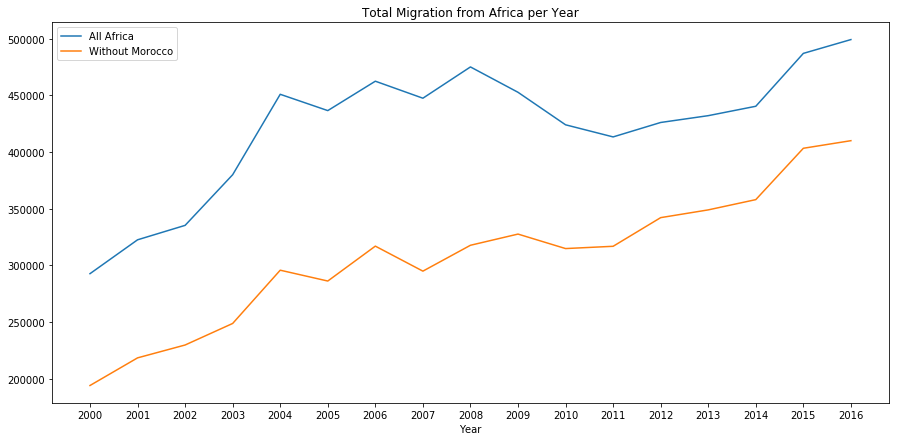

In [121]:

plt.figure(figsize=(15,7))
plt.title('Total Migration from Africa per Year')
sns.lineplot(x=anual_migration.index, y=anual_migration.values, label='All Africa')
sns.lineplot(x=anual_migration.index, y=anual_migration_without_morocco.values,label='Without Morocco')

<h4>Migration and Gnp per capita</h4>

In [122]:
countries_by_gdp = africa.groupby(by=['Country Name'])['Gdp_capita'].mean()

In [123]:
top10_gdp = countries_by_gdp.sort_values(ascending=False)[0:10]

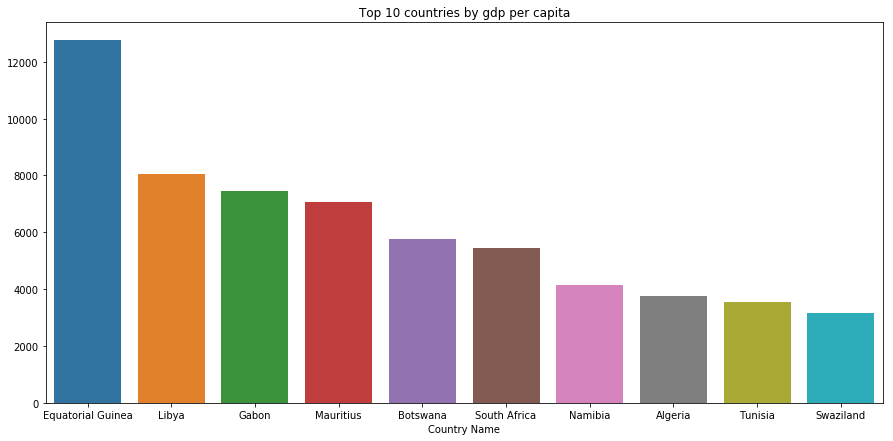

In [124]:
plt.figure(figsize=(15,7))
plt.title('Top 10 countries by gdp per capita')
sns.barplot(top10_gdp.index,top10_gdp.values)
plt.show()

C:\Users\Carlos\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


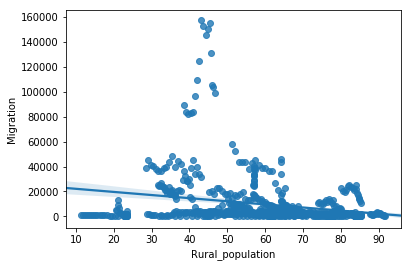

In [125]:
sns.regplot(x=africa['Rural_population'], y=africa['Migration'], fit_reg=True)
plt.show()

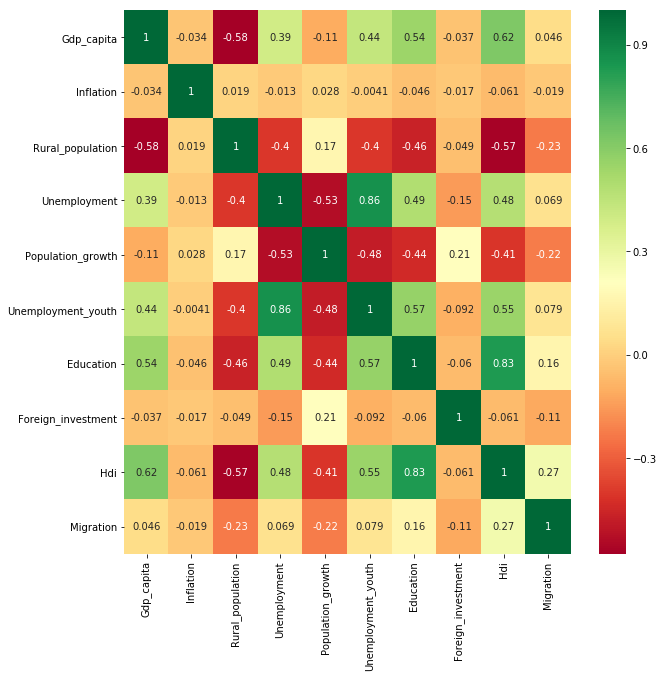

In [126]:
# most correlated features
corrmat = africa.corr()
top_corr_features = corrmat.index[abs(corrmat["Migration"])>0.00]
plt.figure(figsize=(10,10))
g = sns.heatmap(africa[top_corr_features].corr(),annot=True,cmap="RdYlGn")

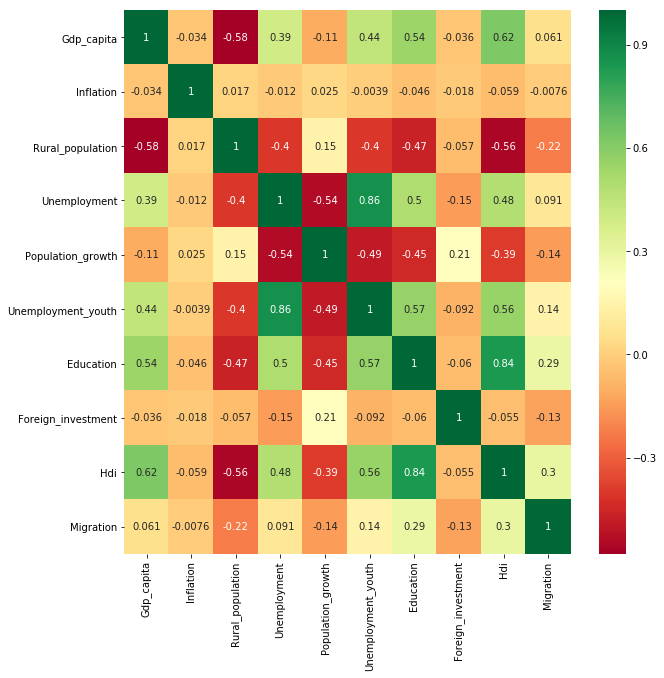

In [127]:

# most correlated features
corrmat = africa_without_morocco.corr()
top_corr_features = corrmat.index[abs(corrmat["Migration"])>0.00]
plt.figure(figsize=(10,10))
g = sns.heatmap(africa_without_morocco[top_corr_features].corr(),annot=True,cmap="RdYlGn")

In [128]:

categorical_columns= list(africa.select_dtypes(include='object'))



In [129]:
categorical_columns

['Country Name', 'Country Code', 'Year']

<h3>Data Preprocessing for Machine Learning</h3>

In [130]:
africa.shape

(731, 13)

In [131]:
africa.drop(['Country Code'],axis=1,inplace = True)

In [132]:
Y=africa.Migration

In [133]:
africa_2=africa.copy()

In [134]:
africa_2.head()

,Country Name,Year,Gdp_capita,Inflation,Rural_population,Unemployment,Population_growth,Unemployment_youth,Education,Foreign_investment,Hdi,Migration
0,Algeria,2000,1765.022577,22.654767,40.081,29.770000,1.358408,52.00,500.0,0.50,0.644,24918.0
1,Algeria,2001,1740.606649,-0.481508,39.288,27.299999,1.309843,47.74,513.0,0.62,0.653,28388.0
2,Algeria,2002,1781.826864,1.311488,38.499,25.900000,1.275066,43.48,529.0,0.74,0.664,36637.0
3,Algeria,2003,2103.381467,8.328836,37.716,23.719999,1.275915,39.22,542.0,0.86,0.674,42361.0
4,Algeria,2004,2609.952692,12.245876,36.939,17.650000,1.317846,34.96,557.0,0.98,0.684,44840.0


In [135]:
africa.drop('Migration',axis=1,inplace= True)

Create Dummies for the categorical variables

In [136]:
africa = pd.get_dummies(africa, prefix=['Year','Country Name'],
               columns=['Year','Country Name'])

In [137]:
all_data_num_columns = list(africa.select_dtypes(include='float'))

Scaling the features

In [138]:
X_train, X_test, y_train, y_test = train_test_split(africa,Y,test_size=0.10,random_state = 0)

In [139]:
lassoreg = Lasso(random_state=0)
lasso_modell = lassoreg.fit(X_train,y_train)
lasso_pred = lasso_modell.predict(X_test)
print(explained_variance_score(y_test,lasso_pred))
print(r2_score(y_test,lasso_pred))

0.9603002561796532
0.9601207428893976


C:\Users\Carlos\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


In [140]:
from sklearn.linear_model import Ridge
ridgereg = Ridge(random_state = 0)
ridgereg.fit(X_train,y_train)
ridgepred = ridgereg.predict(X_test)
print(explained_variance_score(y_test,ridgepred)) 
print(np.sqrt(mean_squared_error(y_test,ridgepred)))

0.9620175642297442
3970.8618090185173


In [141]:
gbreg_params={'learning_rate':[0.5,0.1, 0.05, 0.01],'n_estimators':[600,800,1000],
              'max_depth': [2,4,6],'min_samples_split':[6,8,10]}
gbreg_opt = GradientBoostingRegressor()

In [142]:
random_gb = RandomizedSearchCV(gbreg_opt, param_distributions=gbreg_params,
                                  n_iter=10,cv=3,scoring='explained_variance',
                               random_state=0)

random_result_gb = random_gb.fit(X_train,y_train)
print(random_result_gb.best_params_,random_result_gb.best_score_) 

{'n_estimators': 600, 'min_samples_split': 8, 'max_depth': 6, 'learning_rate': 0.05} 0.9567981304984485


In [143]:
pred_gb = random_gb.best_estimator_.predict(X_test)

In [144]:
print(explained_variance_score(y_test,pred_gb)) 

0.9772186063368542


In [145]:
rf_params={'n_estimators':[100,150,200,400,800],'min_samples_leaf': [1, 2, 4], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80],
          'min_samples_leaf': [1, 2, 4]}
rf_opt=RandomForestRegressor()

In [146]:
random_rf = RandomizedSearchCV(rf_opt, param_distributions=rf_params,
                                  n_iter=10,cv=3,scoring='explained_variance',
                               random_state=0)

random_result_rf = random_rf.fit(X_train,y_train)
print(random_result_rf.best_params_,random_result_rf.best_score_) 

{'n_estimators': 800, 'min_samples_leaf': 1, 'max_depth': 70} 0.9602071135743576


In [147]:
XGBreg_params={'learning_rate':[0.1, 0.05, 0.01,0.001],'n_estimators':[3400,3700,3900,4000],
              'max_depth':[2,3,6], 'colsample_bytree':[0.2,0.3,0.4]}
XGBreg_opt = XGBRegressor()

In [148]:
random_XGB = RandomizedSearchCV(XGBreg_opt, param_distributions=XGBreg_params,n_iter=15,cv=5, scoring='explained_variance',random_state=0)
random_result_XGB = random_XGB.fit(X_train,y_train)
print(random_result_XGB.best_params_,random_result_XGB.best_score_)

{'n_estimators': 3900, 'max_depth': 2, 'learning_rate': 0.05, 'colsample_bytree': 0.4} 0.9441956943124996


In [149]:
pred_xgb =random_XGB.best_estimator_.predict(X_test)

In [150]:
print(explained_variance_score(y_test,pred_xgb)) 

0.9874621561525477


In [151]:
pred_rf = random_rf.best_estimator_.predict(X_test)

In [152]:
avg_2_pred = (pred_rf+pred_gb+pred_xgb)/3

In [153]:
print(explained_variance_score(y_test,avg_2_pred)) 
print(r2_score(y_test,avg_2_pred)) 

0.9892883276799517
0.9891553296264913


In [154]:
print(np.sqrt(mean_squared_error(y_test,avg_2_pred)))

2120.0879775313288


In [155]:
difference = (avg_2_pred-y_test)

In [156]:
results =pd.DataFrame({'Pred':avg_2_pred, 'Real':y_test,'Diff':difference})

In [157]:
results.shape

(74, 3)

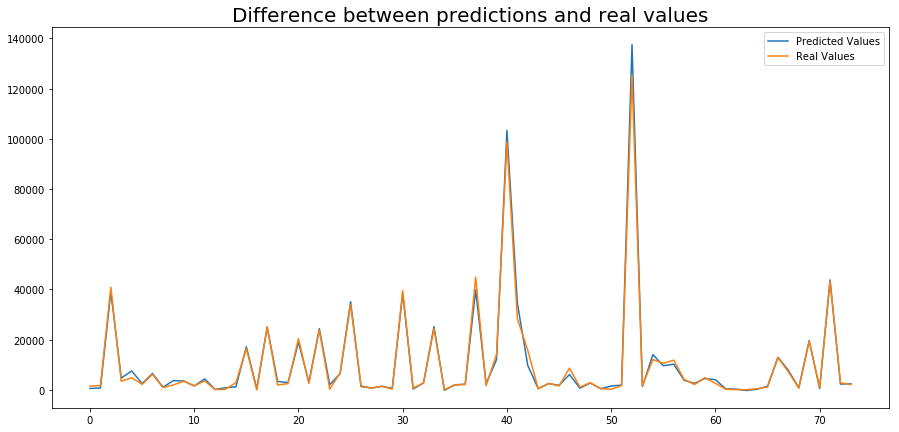

In [158]:
results.reset_index(drop=True, inplace=True)
plt.figure(figsize=(15,7))
plt.title('Difference between predictions and real values',  fontsize=20)
sns.lineplot(x=results.index, y=results.Pred.values, label='Predicted Values')
sns.lineplot(x=results.index, y=results.Real.values, label='Real Values')

<h3>Predicting Migration Outflows two years into the future</h3>

The results form the modell are reasonable good, but there is a catch. We are predicting this years, or past years migration flows based on data from this year. So the next step is to find out out if we can predict next years migrations based on the data that we know from this year or past years. Taking into account that there is a timedelay between the publication of Macroeconic data and the period they are referring I will use a 2 year timeframe/difference for the learning process.

<h4>Implementation</h4>

The idea is actually very simple. I will move all the target variables two positions up in the Dataframe so that for example, the target variable for the Year 2005 matches the attributes for the year 2007. In order to match the length of the attributes with the length of the target variable I will have to remove the last two years per country from the features during the learning process.
The last two years will afterwards be used as the testing set.


In [159]:
#Create a dataframe that holds the target variable
Future_Migration=africa_2[['Country Name','Year','Migration']]

In [160]:
Actual_Features = africa_2

In [161]:
africa_2.head()

,Country Name,Year,Gdp_capita,Inflation,Rural_population,Unemployment,Population_growth,Unemployment_youth,Education,Foreign_investment,Hdi,Migration
0,Algeria,2000,1765.022577,22.654767,40.081,29.770000,1.358408,52.00,500.0,0.50,0.644,24918.0
1,Algeria,2001,1740.606649,-0.481508,39.288,27.299999,1.309843,47.74,513.0,0.62,0.653,28388.0
2,Algeria,2002,1781.826864,1.311488,38.499,25.900000,1.275066,43.48,529.0,0.74,0.664,36637.0
3,Algeria,2003,2103.381467,8.328836,37.716,23.719999,1.275915,39.22,542.0,0.86,0.674,42361.0
4,Algeria,2004,2609.952692,12.245876,36.939,17.650000,1.317846,34.96,557.0,0.98,0.684,44840.0


In [162]:
#Remove the two first years for each country.
Future_Migration = Future_Migration.drop(Future_Migration[(Future_Migration.Year=='2000')].index)

In [163]:
Future_Migration.head(2)

,Country Name,Year,Migration
1,Algeria,2001,28388.0
2,Algeria,2002,36637.0


In [164]:
#Align the features so the target variable from the future matches the data from the present
Actual_Features = Actual_Features.drop(Actual_Features[(Actual_Features.Year=='2016')].index)

In [165]:
#reset the indices so that features and target match
Actual_Features = Actual_Features.reset_index(drop=True, inplace=False)

In [166]:
Future_Migration = Future_Migration.reset_index(drop=True, inplace=False)

In [167]:
futurearray = Future_Migration.Migration.values

In [168]:
Actual_Features['Migration'] = futurearray

In [169]:
Actual_Features.head(2)

,Country Name,Year,Gdp_capita,Inflation,Rural_population,Unemployment,Population_growth,Unemployment_youth,Education,Foreign_investment,Hdi,Migration
0,Algeria,2000,1765.022577,22.654767,40.081,29.770000,1.358408,52.00,500.0,0.50,0.644,28388.0
1,Algeria,2001,1740.606649,-0.481508,39.288,27.299999,1.309843,47.74,513.0,0.62,0.653,36637.0


In [170]:
Actual_Features.tail(2)

,Country Name,Year,Gdp_capita,Inflation,Rural_population,Unemployment,Population_growth,Unemployment_youth,Education,Foreign_investment,Hdi,Migration
686,Zimbabwe,2014,1434.899340,-0.252141,67.496,5.518,1.754692,11.4,558.0,3.0,0.525,3590.0
687,Zimbabwe,2015,1445.071062,0.607814,67.615,5.438,1.663813,11.4,558.0,2.4,0.529,2835.0


In [171]:
Y_f=Actual_Features.Migration

In [172]:
Actual_Features.shape

(688, 12)

In [173]:
Y_f.shape

(688,)

In [174]:
Actual_Features.drop('Migration',axis=1,inplace= True)

In [175]:
Actual_Features = pd.get_dummies(Actual_Features, prefix=['Year','Country Name'],
               columns=['Year','Country Name'])

In [176]:
all_data_num_columns = list(Actual_Features.select_dtypes(include='float'))

In [177]:
#Scale fetures

In [178]:
X_train, X_test, y_train, y_test = train_test_split(Actual_Features,Y_f,test_size=0.10,random_state = 0)

In [179]:
gbreg_params={'learning_rate':[0.5,0.1, 0.05, 0.01],'n_estimators':[600,800,1000,1200],
              'max_depth': [2,4,6],'min_samples_split':[4,6,8]}
gbreg_opt = GradientBoostingRegressor()

In [180]:
random_gb = RandomizedSearchCV(gbreg_opt, param_distributions=gbreg_params,
                                  n_iter=10,cv=3,scoring='explained_variance',
                               random_state=0)

random_result_gb = random_gb.fit(X_train,y_train)
print(random_result_gb.best_params_,random_result_gb.best_score_) 

{'n_estimators': 800, 'min_samples_split': 6, 'max_depth': 4, 'learning_rate': 0.05} 0.9643991018485973


In [181]:
rf_params={'n_estimators':[100,150,200,400,800],'min_samples_leaf': [1, 2, 4], 'max_depth': [4,6,10, 20, 30, 40],
          'min_samples_leaf': [1, 2, 4]}
rf_opt=RandomForestRegressor()

In [182]:
random_rf = RandomizedSearchCV(rf_opt, param_distributions=rf_params,
                                  n_iter=10,cv=3,scoring='explained_variance',
                               random_state=0)

random_result_rf = random_rf.fit(X_train,y_train)
print(random_result_rf.best_params_,random_result_rf.best_score_)

{'n_estimators': 100, 'min_samples_leaf': 1, 'max_depth': 20} 0.9605343570979843


In [183]:
XGBreg_params={'learning_rate':[0.1, 0.05, 0.01,0.001],'n_estimators':[3400,3700,3900,4000],
              'max_depth':[2,4,6,8], 'colsample_bytree':[0.2,0.3,0.4]}
XGBreg_opt = XGBRegressor()

In [184]:
random_XGB = RandomizedSearchCV(XGBreg_opt, param_distributions=XGBreg_params,n_iter=15,cv=5, scoring='explained_variance',random_state=0)
random_result_XGB = random_XGB.fit(X_train,y_train)
print(random_result_XGB.best_params_,random_result_XGB.best_score_)

{'n_estimators': 3700, 'max_depth': 2, 'learning_rate': 0.05, 'colsample_bytree': 0.4} 0.9539718398838473


In [190]:
pred_xgb =random_XGB.best_estimator_.predict(X_test)
pred_gb =random_gb.best_estimator_.predict(X_test)

In [191]:
print(explained_variance_score(y_test,pred_xgb)) 

0.9686309958004266


In [192]:
print(pred_rf.shape,pred_gb.shape,pred_xgb.shape)

(69,) (69,) (69,)


In [187]:
pred_rf = random_rf.best_estimator_.predict(X_test)

In [194]:
avg_3_pred = (pred_rf+pred_gb+pred_xgb)/3

In [195]:
print(explained_variance_score(y_test,avg_3_pred)) 
print(r2_score(y_test,avg_3_pred)) 

0.9723290566483591
0.9722454276117042


In [196]:
print(np.sqrt(mean_squared_error(y_test,avg_2_pred)))

4257.874587386092


In [197]:
difference = (avg_2_pred-y_test)

In [198]:
results =pd.DataFrame({'Pred':avg_2_pred, 'Real':y_test,'Diff':difference})

In [199]:
print(results.Real.sum(),results.Pred.sum())

1019013.004 1002886.017108829


In [200]:
results.head(80)

,Pred,Real,Diff
468,1099.393872,763.002,336.391872
31,3895.765422,3512.000,383.765422
1,36933.045931,36637.000,296.045931
499,1171.531559,502.000,669.531559
601,2876.821056,3338.000,-461.178944
390,558.111112,376.000,182.111112
616,3920.422438,4172.000,-251.577562
315,9957.525999,11340.000,-1382.474001
215,22698.639927,20783.000,1915.639927
331,625.223619,70.000,555.223619


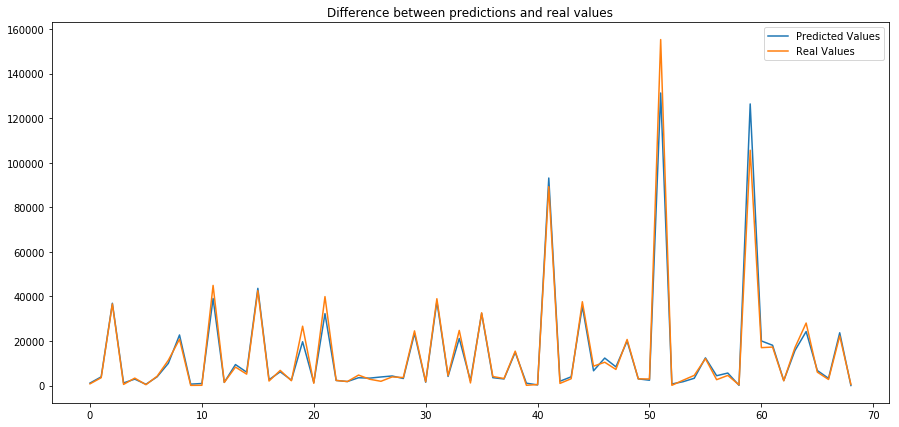

In [201]:
results.reset_index(drop=True, inplace=True)
plt.figure(figsize=(15,7))
plt.title('Difference between predictions and real values')
sns.lineplot(x=results.index, y=results.Pred.values, label='Predicted Values')
sns.lineplot(x=results.index, y=results.Real.values, label='Real Values')